# Objective

1.   Fit a AR(p) model to predict returns
2.   Split data into train and test to determine goodness of fit using RMSE as a measure



# 0 Install, Load packages, Download data and Clean it

## 0.0 Download Packages

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 7.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=51384d74ec52bc12fe31cd15abb76c8c06d9e106625a45d0b2b1271acb501707
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install sklearn

## 0.1 Install Packages

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


## 0.2 Download Data

Fix Parameters to be used through out
a. Stocks to work on
b. Start and End Date

In [ ]:
start_date = pd.to_datetime("2005-01-03")
end_date = pd.to_datetime("2019-01-01")

stocks2Get = [ "AAPL","AMZN", "MSFT", "SPY"]
N = len(stocks2Get)
m,n= int(np.ceil(N/4)), 4

In [ ]:
print(stocks2Get)

['AAPL', 'AMZN', 'MSFT', 'SPY']


## 0.3 Create Returns from data

In [ ]:
#Selecting the start to be 5yrs from todays date. 
start_date = pd.to_datetime("2005-01-01")
#Getting the adjusted close stock prices of 7 stocks , spanned across 5 industries. 
stock_price = yf.download(tickers = stocks2Get,
                          start = start_date , 
                          end = end_date , 
                          progress=False)["Adj Close"]
                          

In [ ]:
stock_price.head()

,AAPL,AMZN,MSFT,SPY
Date,,,,
2005-01-03,0.971844,44.520000,19.108891,87.136215
2005-01-04,0.981825,42.139999,19.180344,86.071442
2005-01-05,0.990424,41.770000,19.137478,85.477493
2005-01-06,0.991192,41.049999,19.116039,85.912079
2005-01-07,1.063362,42.320000,19.058872,85.788956


### 0.3.1 Plot Stocks

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f5f603710>,
      dtype=object)

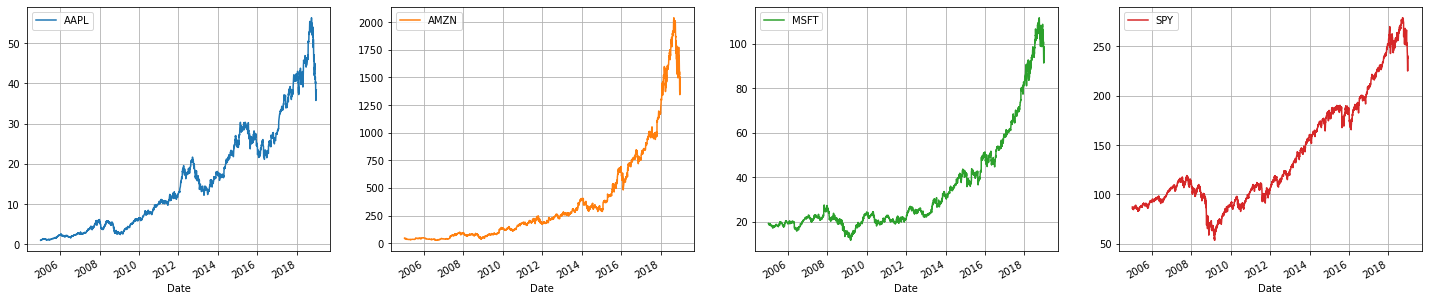

In [ ]:
stock_price.plot(subplots=True, layout=(m, n), figsize=(25,5), grid="both")

## 0.4 Calculate Returns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f613f2c10>,
      dtype=object)

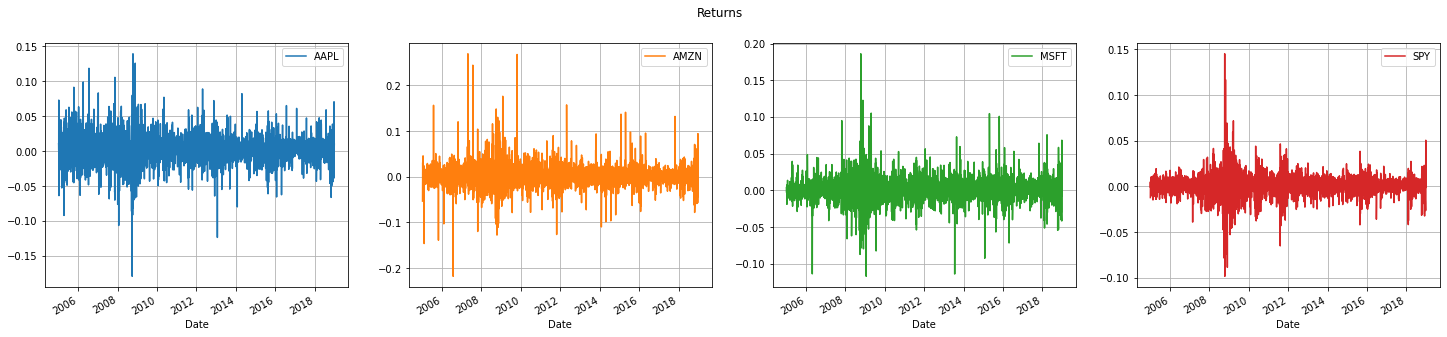

In [ ]:
rets = stock_price.div(stock_price.shift(1)).sub(1)
rets.plot(subplots=True, layout=(m,n), figsize=(25,5), grid="both", title="Returns")
#rets = rets.dropna() # https://stackoverflow.com/questions/63471170/how-do-i-solve-the-valueerror-that-occurs-when-i-run-arima-from-statsmodels

## 0.5 Split Data into Train and Test

In [ ]:
train_rets, test_rets = sklearn.model_selection.train_test_split(rets, train_size=0.7, random_state=42,shuffle=False)

## 0.5.1 Visualized Splits

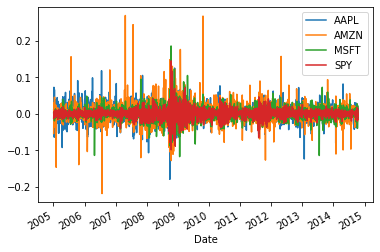

In [ ]:
train_rets.plot()

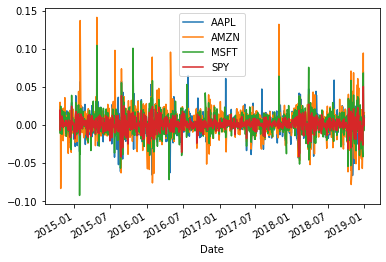

In [ ]:
test_rets.plot()

# 2.0 Exploratory Data Analysis

In [ ]:
allMdl = [];
adfDf = pd.DataFrame(np.zeros([N, 3]), columns=["ADF TStat", "ADF p-vlaue", "ADF Max Lags"], index=stocks2Get)
for i in range(len(rets.columns)):
  thisADFMdl = sm.tsa.adfuller(train_rets.iloc[:,i].dropna())
  allMdl.append(thisADFMdl)
  adfDf.iloc[i,:] = thisADFMdl[:3];


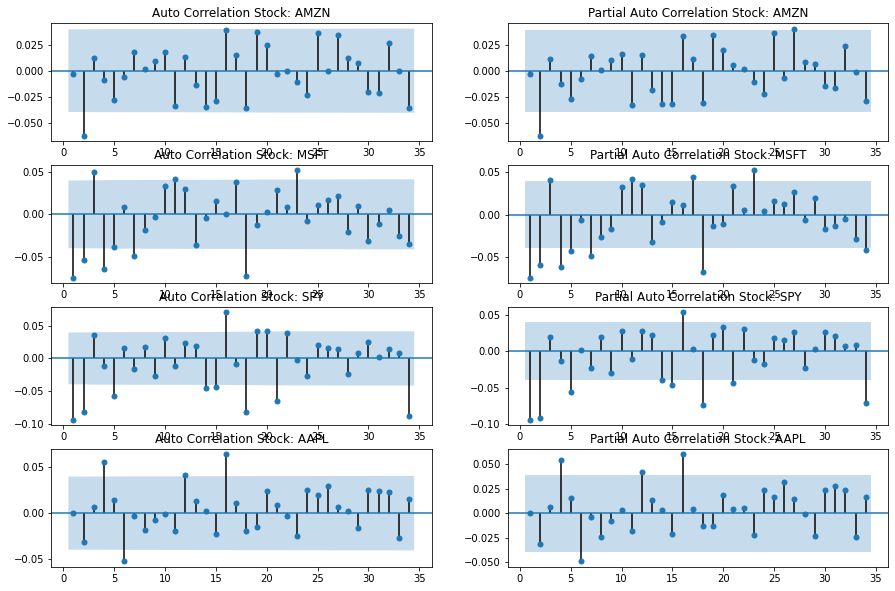

In [ ]:
fig, ax = plt.subplots(N,2,figsize=(15,10))
for i in range(len(rets.columns)):
  sm.graphics.tsa.plot_acf(train_rets.iloc[:,i].dropna(), ax=ax[i-1,0],title="Auto Correlation Stock: {}".format(stocks2Get[i]),zero=False)
  sm.graphics.tsa.plot_pacf(train_rets.iloc[:,i].dropna(), ax=ax[i-1,1],title="Partial Auto Correlation Stock: {}".format(stocks2Get[i]),zero=False)

# 3.0 Fit AR Model
**Observations**:
In all cases, RMSE[Test] <  RMSE[Train]; this does suggest No overfit. However, various combinations yield almost similar RMSEs. This is probably because Most significant part of the regression is the intercept

### 3.0.1 Create a function that can create lagged data frames.

In [ ]:
def getYAndLaggedX(rets = rets, maxHorizon=4, allHorizon=None):
  """ Create Data frame ready with lagged Features. use All Horizons to create specific lagged features
  Use max Horizon to create continuous lags.
  Args:
    rets
    maxHorizons
  Returns:
    listOfy_X (first column is the target variable), listOfY
  """
  listOfY = []
  listOfy_X = []
  # i=0
  print(stocks2Get)
  
  if not allHorizon:
    allHz = range(1, (maxHorizon)+1)
  else:
    allHz = allHorizon

  for i in range(rets.shape[1]):
    thisY = pd.DataFrame(rets.iloc[:, i])
    thisX = pd.DataFrame(rets.iloc[:, i])
    stkName = stocks2Get[i]
    print(i, stkName,  stocks2Get[i])
    for j,v in enumerate(allHz):
      thisX[stkName + "_{}".format(v)] = thisY.shift(v)
    listOfY.append(thisY)
    listOfy_X.append(thisX.dropna())
    
  return [listOfy_X, listOfY]

In [ ]:
listOfy_X,lY = getYAndLaggedX(rets, maxHorizon=8)

['AAPL', 'AMZN', 'MSFT', 'SPY']
0 AAPL AAPL
1 AMZN AMZN
2 MSFT MSFT
3 SPY SPY


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1f5cd037d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1f5cd037d0>)

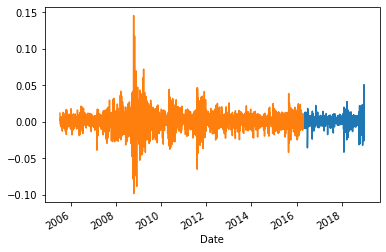

In [ ]:
#testX.plot(), trainX.plot()
testY.plot(), trainY.plot()

## 3.1 Fit AR with continuous lags of 1:8

Train RMSE: 0.022, Test RMSE: 0.014
Train RMSE: 0.026, Test RMSE: 0.018
Train RMSE: 0.017, Test RMSE: 0.014
Train RMSE: 0.012, Test RMSE: 0.008


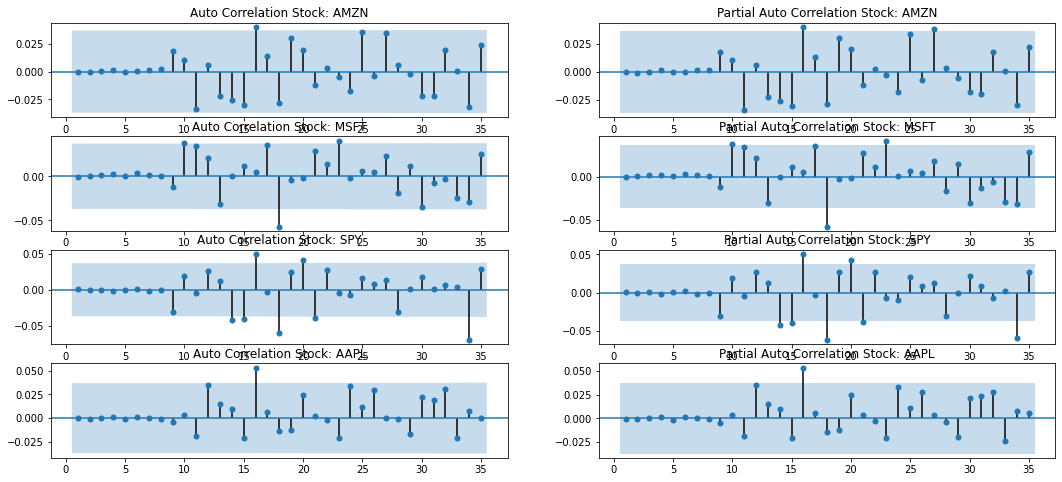

In [ ]:
fig, ax = plt.subplots(N,2,figsize=(18,8))
for i in range(len(stocks2Get)):
  trainX, testX,trainY, testY = sklearn.model_selection.train_test_split(listOfy_X[i].iloc[:,1:], listOfy_X[i].iloc[:,0],train_size=0.8,shuffle=False)
  #print(trainX.head())
  lm = LinearRegression(fit_intercept=True);
  lm.fit(X=trainX, y=trainY)
  #print(lm.coef_, lm.intercept_)

  y_Train_Pred = lm.predict(trainX)
  y_Test_Pred = lm.predict(testX)

  trainRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_Train_Pred, trainY))
  #print(y_Train_Pred[:10])
  testRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_Test_Pred, testY))
  #print("Train MSE: {1.{digits}f} Test MSE: {1.{digits}f}".format(trainMSE, testMSE, digits=3))
  #print(trainRMSE, testRMSE)
  print("Train RMSE: {0:.{digits}f}, Test RMSE: {1:.{digits}f}".format(trainRMSE, testRMSE, digits=3))
  trainResids = y_Train_Pred- trainY
  #plot_acf(trainResids, zero=False,)

  sm.graphics.tsa.plot_acf(trainResids, ax=ax[i-1,0],title="Auto Correlation Stock: {}".format(stocks2Get[i]),zero=False)
  sm.graphics.tsa.plot_pacf(trainResids, ax=ax[i-1,1],title="Partial Auto Correlation Stock: {}".format(stocks2Get[i]),zero=False)

## 3.2 Fit AR with specific lags allHorizon=[1,2,3,15,22]

In [ ]:
listOfy_X1,lY1 = getYAndLaggedX(rets, maxHorizon=8, allHorizon=[1,2,3,15,22])

['AAPL', 'AMZN', 'MSFT', 'SPY']
0 AAPL AAPL
1 AMZN AMZN
2 MSFT MSFT
3 SPY SPY


Train RMSE: 0.022, Test RMSE: 0.014
Train RMSE: 0.026, Test RMSE: 0.018
Train RMSE: 0.017, Test RMSE: 0.014
Train RMSE: 0.012, Test RMSE: 0.008


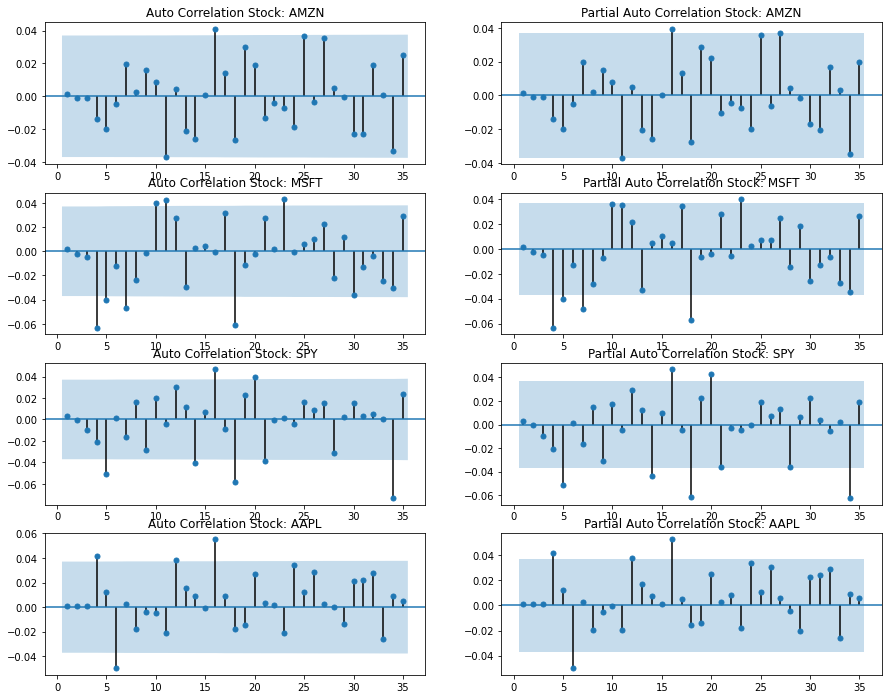

In [ ]:
fig, ax = plt.subplots(N,2,figsize=(15,12))
for i in range(len(stocks2Get)):
  trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(listOfy_X1[i].iloc[:,1:], listOfy_X1[i].iloc[:,0],train_size=0.8,shuffle=False)
  #print(trainX.head())
  lm = LinearRegression(fit_intercept=True);
  lm.fit(X=trainX, y=trainY)
  #print(lm.coef_, lm.intercept_)
  y_Train_Pred = lm.predict(trainX)
  y_Test_Pred = lm.predict(testX)
  #print(y_Test_Pred[:10])
  trainRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_Train_Pred, trainY))
  testRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_Test_Pred, testY))
  #print("Train MSE: {1.{digits}f} Test MSE: {1.{digits}f}".format(trainMSE, testMSE, digits=3))
  #print(trainRMSE, testRMSE)
  print("Train RMSE: {0:.{digits}f}, Test RMSE: {1:.{digits}f}".format(trainRMSE, testRMSE, digits=3))
  trainResids = y_Train_Pred- trainY
  #plot_acf(trainResids, zero=False,)

  sm.graphics.tsa.plot_acf(trainResids, ax=ax[i-1,0],title="Auto Correlation Stock: {}".format(stocks2Get[i]),zero=False)
  sm.graphics.tsa.plot_pacf(trainResids, ax=ax[i-1,1],title="Partial Auto Correlation Stock: {}".format(stocks2Get[i]),zero=False)

## 3.3 Fit AR with specific lags maxHorizon=30

['AAPL', 'AMZN', 'MSFT', 'SPY']
0 AAPL AAPL
1 AMZN AMZN
2 MSFT MSFT
3 SPY SPY
Train RMSE: 0.022, Test RMSE: 0.015
Train RMSE: 0.026, Test RMSE: 0.018
Train RMSE: 0.017, Test RMSE: 0.014
Train RMSE: 0.012, Test RMSE: 0.008


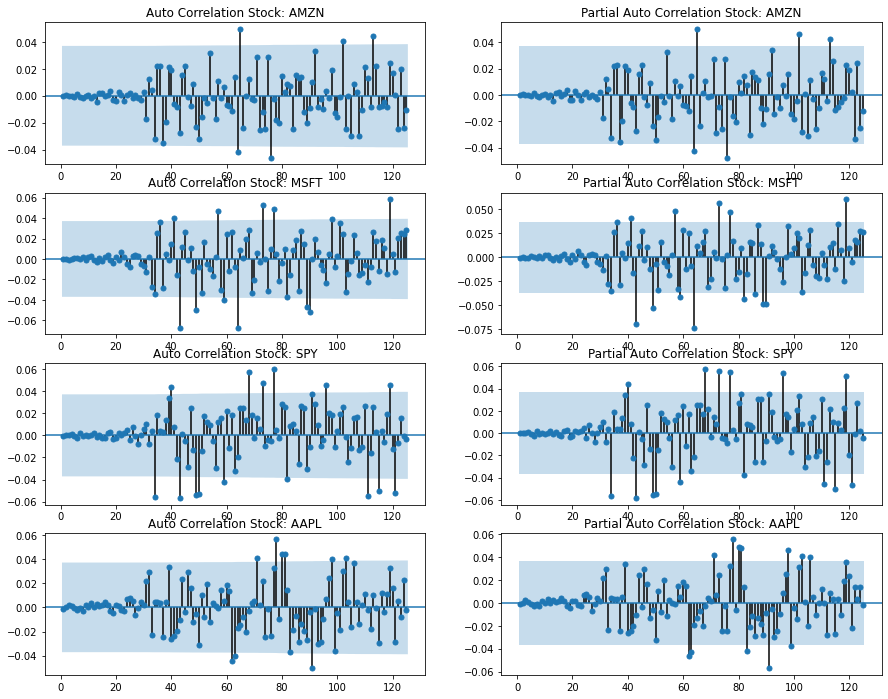

In [ ]:
listOfy_X1,lY1 = getYAndLaggedX(rets, maxHorizon=30)
fig, ax = plt.subplots(N,2,figsize=(15,12))
for i in range(len(stocks2Get)):
  trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(listOfy_X1[i].iloc[:,1:], listOfy_X1[i].iloc[:,0],train_size=0.8,shuffle=False)
  #print(trainX.head())
  lm = LinearRegression(fit_intercept=True);
  lm.fit(X=trainX, y=trainY)
  #print(lm.coef_, lm.intercept_)
  y_Train_Pred = lm.predict(trainX)
  y_Test_Pred = lm.predict(testX)
  #print(y_Test_Pred[:10])
  trainRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_Train_Pred, trainY))
  testRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_Test_Pred, testY))
  #print("Train MSE: {1.{digits}f} Test MSE: {1.{digits}f}".format(trainMSE, testMSE, digits=3))
  #print(trainRMSE, testRMSE)
  print("Train RMSE: {0:.{digits}f}, Test RMSE: {1:.{digits}f}".format(trainRMSE, testRMSE, digits=3))
  trainResids = y_Train_Pred- trainY
  #plot_acf(trainResids, zero=False,)

  sm.graphics.tsa.plot_acf(trainResids,lags=125, ax=ax[i-1,0],title="Auto Correlation Stock: {}".format(stocks2Get[i]),zero=False)
  sm.graphics.tsa.plot_pacf(trainResids,lags=125, ax=ax[i-1,1],title="Partial Auto Correlation Stock: {}".format(stocks2Get[i]),zero=False)

## 3.4 Fit AR with specific lags allHorizon=[1,2,3,4,5,20,21,22,61,62,63,64,65,123,124,125,126,127,128]

['AAPL', 'AMZN', 'MSFT', 'SPY']
0 AAPL AAPL
1 AMZN AMZN
2 MSFT MSFT
3 SPY SPY
Train RMSE: 0.021, Test RMSE: 0.015
Train RMSE: 0.026, Test RMSE: 0.018
Train RMSE: 0.017, Test RMSE: 0.014
Train RMSE: 0.013, Test RMSE: 0.008


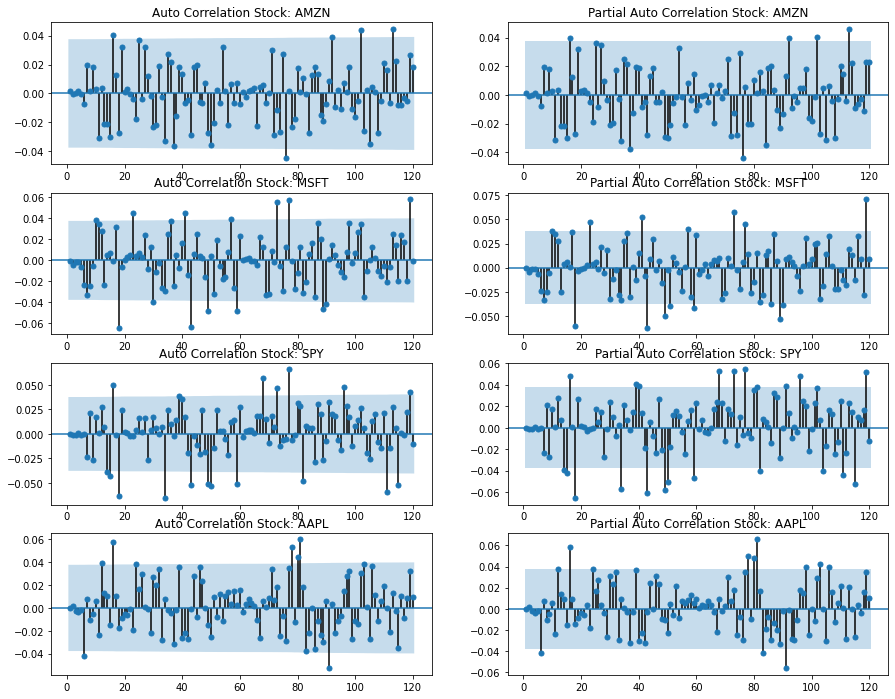

In [ ]:
listOfy_X1,lY1 = getYAndLaggedX(rets, allHorizon=[1,2,3,4,5,20,21,22,61,62,63,64,65,123,124,125,126,127,128])
fig, ax = plt.subplots(N,2,figsize=(15,12))
for i in range(len(stocks2Get)):
  trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(listOfy_X1[i].iloc[:,1:], listOfy_X1[i].iloc[:,0],train_size=0.8,shuffle=False)
  #print(trainX.head())
  lm = LinearRegression(fit_intercept=True);
  lm.fit(X=trainX, y=trainY)
  #print(lm.coef_, lm.intercept_)
  y_Train_Pred = lm.predict(trainX)
  y_Test_Pred = lm.predict(testX)
  #print(y_Test_Pred[:10])
  trainRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_Train_Pred, trainY))
  testRMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_Test_Pred, testY))
  #print("Train MSE: {1.{digits}f} Test MSE: {1.{digits}f}".format(trainMSE, testMSE, digits=3))
  #print(trainRMSE, testRMSE)
  print("Train RMSE: {0:.{digits}f}, Test RMSE: {1:.{digits}f}".format(trainRMSE, testRMSE, digits=3))
  trainResids = y_Train_Pred- trainY
  #plot_acf(trainResids, zero=False,)

  sm.graphics.tsa.plot_acf(trainResids,lags=120, ax=ax[i-1,0],title="Auto Correlation Stock: {}".format(stocks2Get[i]),zero=False)
  sm.graphics.tsa.plot_pacf(trainResids,lags=120, ax=ax[i-1,1],title="Partial Auto Correlation Stock: {}".format(stocks2Get[i]),zero=False)